## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import seaborn as sns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)



## csv to parquet
#### -> 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.

In [2]:
# def csv_to_parquet(csv_path, save_name):
#     df = pd.read_csv(csv_path)
#     df.to_parquet(f'dataset/{save_name}.parquet')
#     del df
#     gc.collect()
#     print(save_name, 'Done.')

In [3]:
# csv_to_parquet('dataset/train.csv', 'train')
# csv_to_parquet('dataset/test.csv', 'test')

## Config

In [4]:
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    FOLDS = 5
    SEED = 42
    VER = 
    lr = 1e-3
    epochs = 200
    
    batch_size = 16

    ##############
    backbone = 'resnet101'
    version = '0.21'
    
CFG = cfg()

SyntaxError: invalid syntax (3563755687.py, line 9)

## 데이터 불러오기

In [5]:
train = pd.read_parquet('dataset/train.parquet')
test = pd.read_parquet('dataset/test.parquet')

## EDA

In [6]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,32400.0,0.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0.0,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [7]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
                        ..
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
Length: 22, dtype: int64

In [ ]:
str_col = ['day_of_week','road_name', 'start_node_name', 'end_node_name', 'start_turn_restricted','end_turn_restricted']
num_col = train.columns.difference(str_col)

<AxesSubplot: >

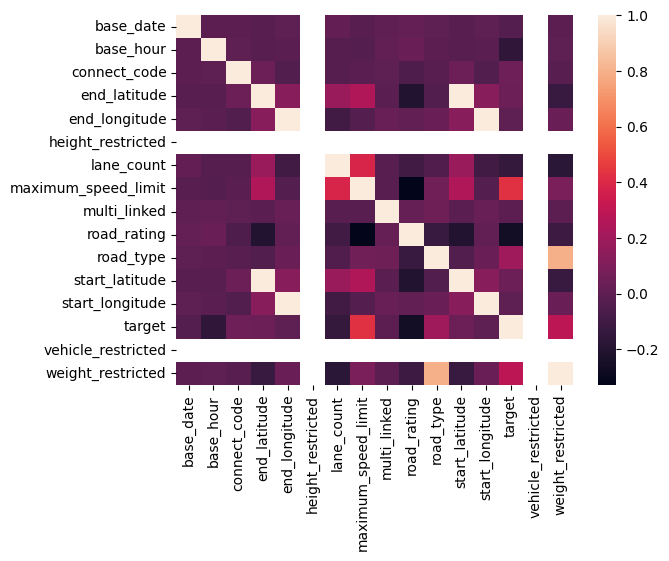

In [ ]:
sns.heatmap(train[num_col].corr())

- 예상하다시피 latitude, lngtitude는 서로 높은 상관관계를 갖고 있음을 볼 수 있음
- height_restricted, vehicle_restricted는 NaN을 보여준다

In [ ]:
train['vehicle_restricted'].unique(), train['height_restricted'].unique(), train['weight_restricted'].unique()

(array([0.]), array([32400.,     0., 43200., 50000.]))

## 데이터 전처리

In [31]:
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [8]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 16)
(4701217,)
(291241, 16)


## 모델 선언 및 학습

In [9]:
LR = lgb.LGBMRegressor(random_state=42, verbose=1).fit(X_train, y_train)

## 추론

In [11]:
pred = LR.predict(test)

## Submission

In [14]:
sample_submission = pd.read_csv('dataset/sample_submission.csv')

In [15]:
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)

In [16]:
sample_submission

,id,target
0,TEST_000000,27.124435
1,TEST_000001,46.209108
2,TEST_000002,59.209591
3,TEST_000003,36.193882
4,TEST_000004,38.112673
...,...,...
291236,TEST_291236,47.581565
291237,TEST_291237,53.091297
291238,TEST_291238,20.823707
291239,TEST_291239,26.472941
